# Project 5: US College COVID-19 Analysis

##### Aziz Maredia, Katherine King, Manuel Sainz de la Peña, Max Bosse | DSIR-1019 | 12.23.20

In [2]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

## Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix

#geopandas
#import geopandas as gpd
#from shapely.geometry import Point, Polygon

In [3]:
#read in combined df dataframe
data = pd.read_csv('datasets/combined_df.csv')

In [4]:
data.shape

(873, 34)

In [5]:
data.columns

Index(['Unnamed: 0', 'state', 'college', 'cases', 'college_size_category',
       'distance_educ_offered', 'admissions_total', 'freshmen_enrollment',
       'admissions_men', 'admissions_women', 'number_freshmen_submitting_sat',
       'number_freshmen_submitting_act', 'sat_ebrw_25', 'sat_ebrw_75',
       'sat_math_25', 'sat_math_75', 'act_comp_25', 'act_comp_75',
       'act_english_25', 'act_english_75', 'act_math_25', 'act_math_75',
       'football_conference', 'region', 'status_reopening',
       'stay_at_home_order', 'large_gatherings', 'restaurant_limits',
       'bar_closures', 'face_coverings', 'class_plan', 'total_enrollment',
       'percent_infected', 'greater_than_5'],
      dtype='object')

In [6]:
#Only uncomment 1 of the below lines of code - 

#1. dummy all policy WITH football categorical variables - 
data_dummy = pd.get_dummies(data, columns = ['football_conference', 'region', 'status_reopening', 'stay_at_home_order', 'large_gatherings', 'restaurant_limits', 'bar_closures', 'face_coverings', 'class_plan'], drop_first = True)

#2. dummy all policy WITHOUT football conference (too many columns)
#data_dummy = pd.get_dummies(data, columns = ['region', 'status_reopening', 'stay_at_home_order', 'large_gatherings', 'bar_closures', 'face_coverings', 'class_plan'], drop_first = True)



In [7]:
data_dummy['greater_than_5'] = data_dummy['greater_than_5'].astype(int)
data = data_dummy.select_dtypes(np.number)
data.shape

(873, 138)

In [8]:
data['greater_than_5'].value_counts()

0    653
1    220
Name: greater_than_5, dtype: int64

#### Feature Engineering


In [9]:
#Add interaction feature to increase weight of schools that are primarily in person AND with bars open and schools primarily online with bars closed. 
data['packed_bars'] = data['class_plan_Primarily in person'] * data['bar_closures_Reopened']
data['empty_bars'] = data['class_plan_Primarily online'] * data['bar_closures_New Service Limits'] 
#Keep original columns because interaction includes binary variable. Still need to capture independent impact on model. 

<ipython-input-9-e435a3b3b229>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['packed_bars'] = data['class_plan_Primarily in person'] * data['bar_closures_Reopened']


In [10]:
#Add interaction feature to amplify the admisisons statistics and simultaneously reduce the number of features. 
data['test_scores_75'] = data['sat_ebrw_75'] * data['sat_math_75'] * data['act_comp_75'] * data['act_english_75'] * data['act_math_75']
data['test_scores_25'] = data['sat_ebrw_25'] * data['sat_math_25'] * data['act_comp_25'] * data['act_english_25'] * data['act_math_25']
#Drop original columns (multicollinearity)
data = data.drop(columns = ['sat_ebrw_75', 'sat_math_75', 'act_comp_75', 'act_english_75', 'act_math_75', 'sat_ebrw_25', 'sat_math_25', 'act_comp_25', 'act_english_25', 'act_math_25'])

In [11]:
data = data.drop(columns = ['Unnamed: 0'])

In [12]:
# Run this cell to get rid of columns that contain information on the size of the institution
#data = data.drop(columns = ['college_size_category', 'admissions_total', 'freshmen_enrollment', 'admissions_men', 'admissions_women', 'number_freshmen_submitting_sat', 'number_freshmen_submitting_act', 'total_enrollment'], inplace = True)

In [13]:
data.shape

(873, 131)

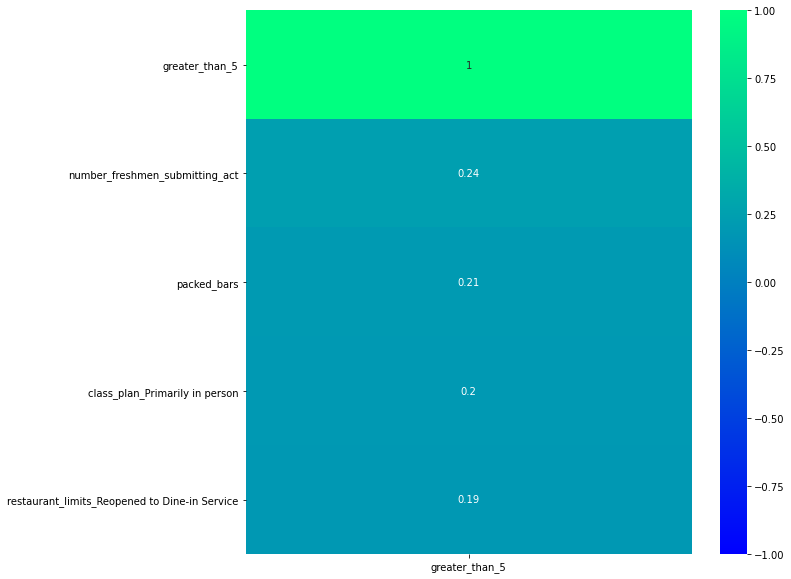

In [22]:
#correlation matrix with target variable
#Note: We will be dropping percent_infected and cases from X. 
data1 = data.drop(columns = ['percent_infected', 'cases'])
corr = data1.corr()[['greater_than_5']].sort_values(by='greater_than_5', ascending = False).head(5)
plt.figure(figsize = (10, 10))
sns.heatmap(corr, cmap='winter', annot = True, vmin=-1, vmax=1)
plt.savefig('./images/correlation_top.png');

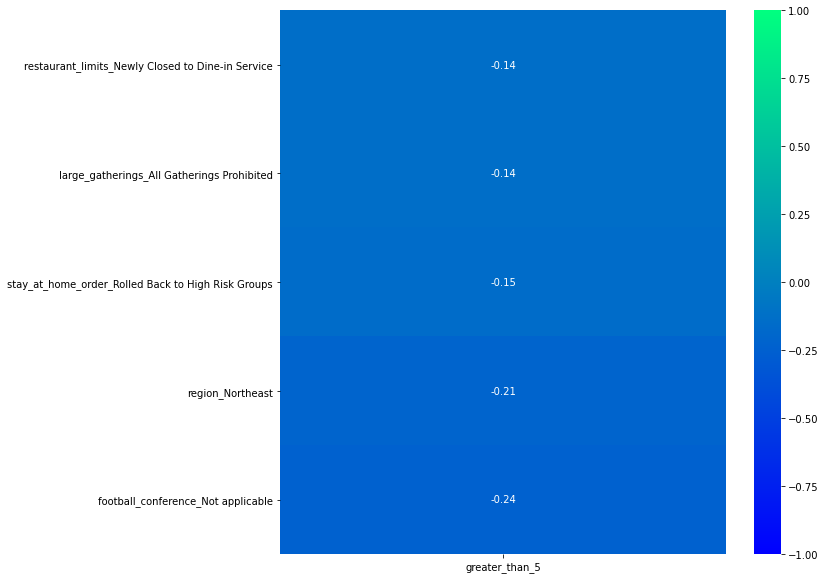

In [21]:
#correlation matrix with target variable
#Note: We will be dropping percent_infected and cases from X. 
data1 = data.drop(columns = ['percent_infected', 'cases'])
corr = data1.corr()[['greater_than_5']].sort_values(by='greater_than_5', ascending = False).tail(5)
plt.figure(figsize = (10, 10))
sns.heatmap(corr, cmap='winter', annot = True, vmin=-1, vmax=1)
plt.savefig('./images/correlation_tail.png');

### Using a catch-all approach to see which classification models perform best on our dataset. 

In [16]:
#Inro modeling to see if any of our classifications are performing noticably better than others. 
log = LogisticRegression()
knnc = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
bagc = BaggingClassifier()
rfc = RandomForestClassifier()
adac = AdaBoostClassifier()
svc = SVC()
models = {
    'log' : log,
    'knn' : knnc,
    'dt' : dtc,
    'bag' : bagc,
    'rf' : rfc,
    'ada' : adac,
    'svr' : svc
}
#X = data2.drop(columns=['greater_than_10', 'percent_infected'])
X = data.drop(columns=['greater_than_5', 'percent_infected', 'cases'])
y = data['greater_than_5']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify = y, random_state=42)

for est in models.values():
    print(est)
    est.fit(X_train, y_train)
    print(est.score(X_test, y_test))
    print('')

LogisticRegression()
0.7485714285714286

KNeighborsClassifier()
0.6228571428571429

DecisionTreeClassifier()
0.7142857142857143

BaggingClassifier()
0.7885714285714286

RandomForestClassifier()
0.8114285714285714

AdaBoostClassifier()
0.8057142857142857

SVC()
0.7485714285714286



### Decision Tree

In [17]:
X = data.drop(columns=['greater_than_5', 'percent_infected', 'cases'])
y = data['greater_than_5']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify = y, random_state=42)

dt = DecisionTreeClassifier()

dt_params = {'max_depth': [2,3,4], 'min_samples_split': [3, 4, 5, 6], 'min_samples_leaf': [7, 9, 11]}

dt_gs = GridSearchCV(dt, dt_params, cv = 5)

dt_gs.fit(X_train, y_train)

best_dt = dt_gs.best_estimator_

print(f'Best Decision Tree Score: {best_dt.score(X_test,y_test)}')
print(f'Best Decision Tree Parameters: {dt_gs.best_params_}')
print(f'Score on training set: {dt_gs.score(X_train, y_train)}')
print(f'Score on testing set: {dt_gs.score(X_test, y_test)}')

Best Decision Tree Score: 0.7657142857142857
Best Decision Tree Parameters: {'max_depth': 4, 'min_samples_leaf': 11, 'min_samples_split': 3}
Score on training set: 0.8137535816618912
Score on testing set: 0.7657142857142857


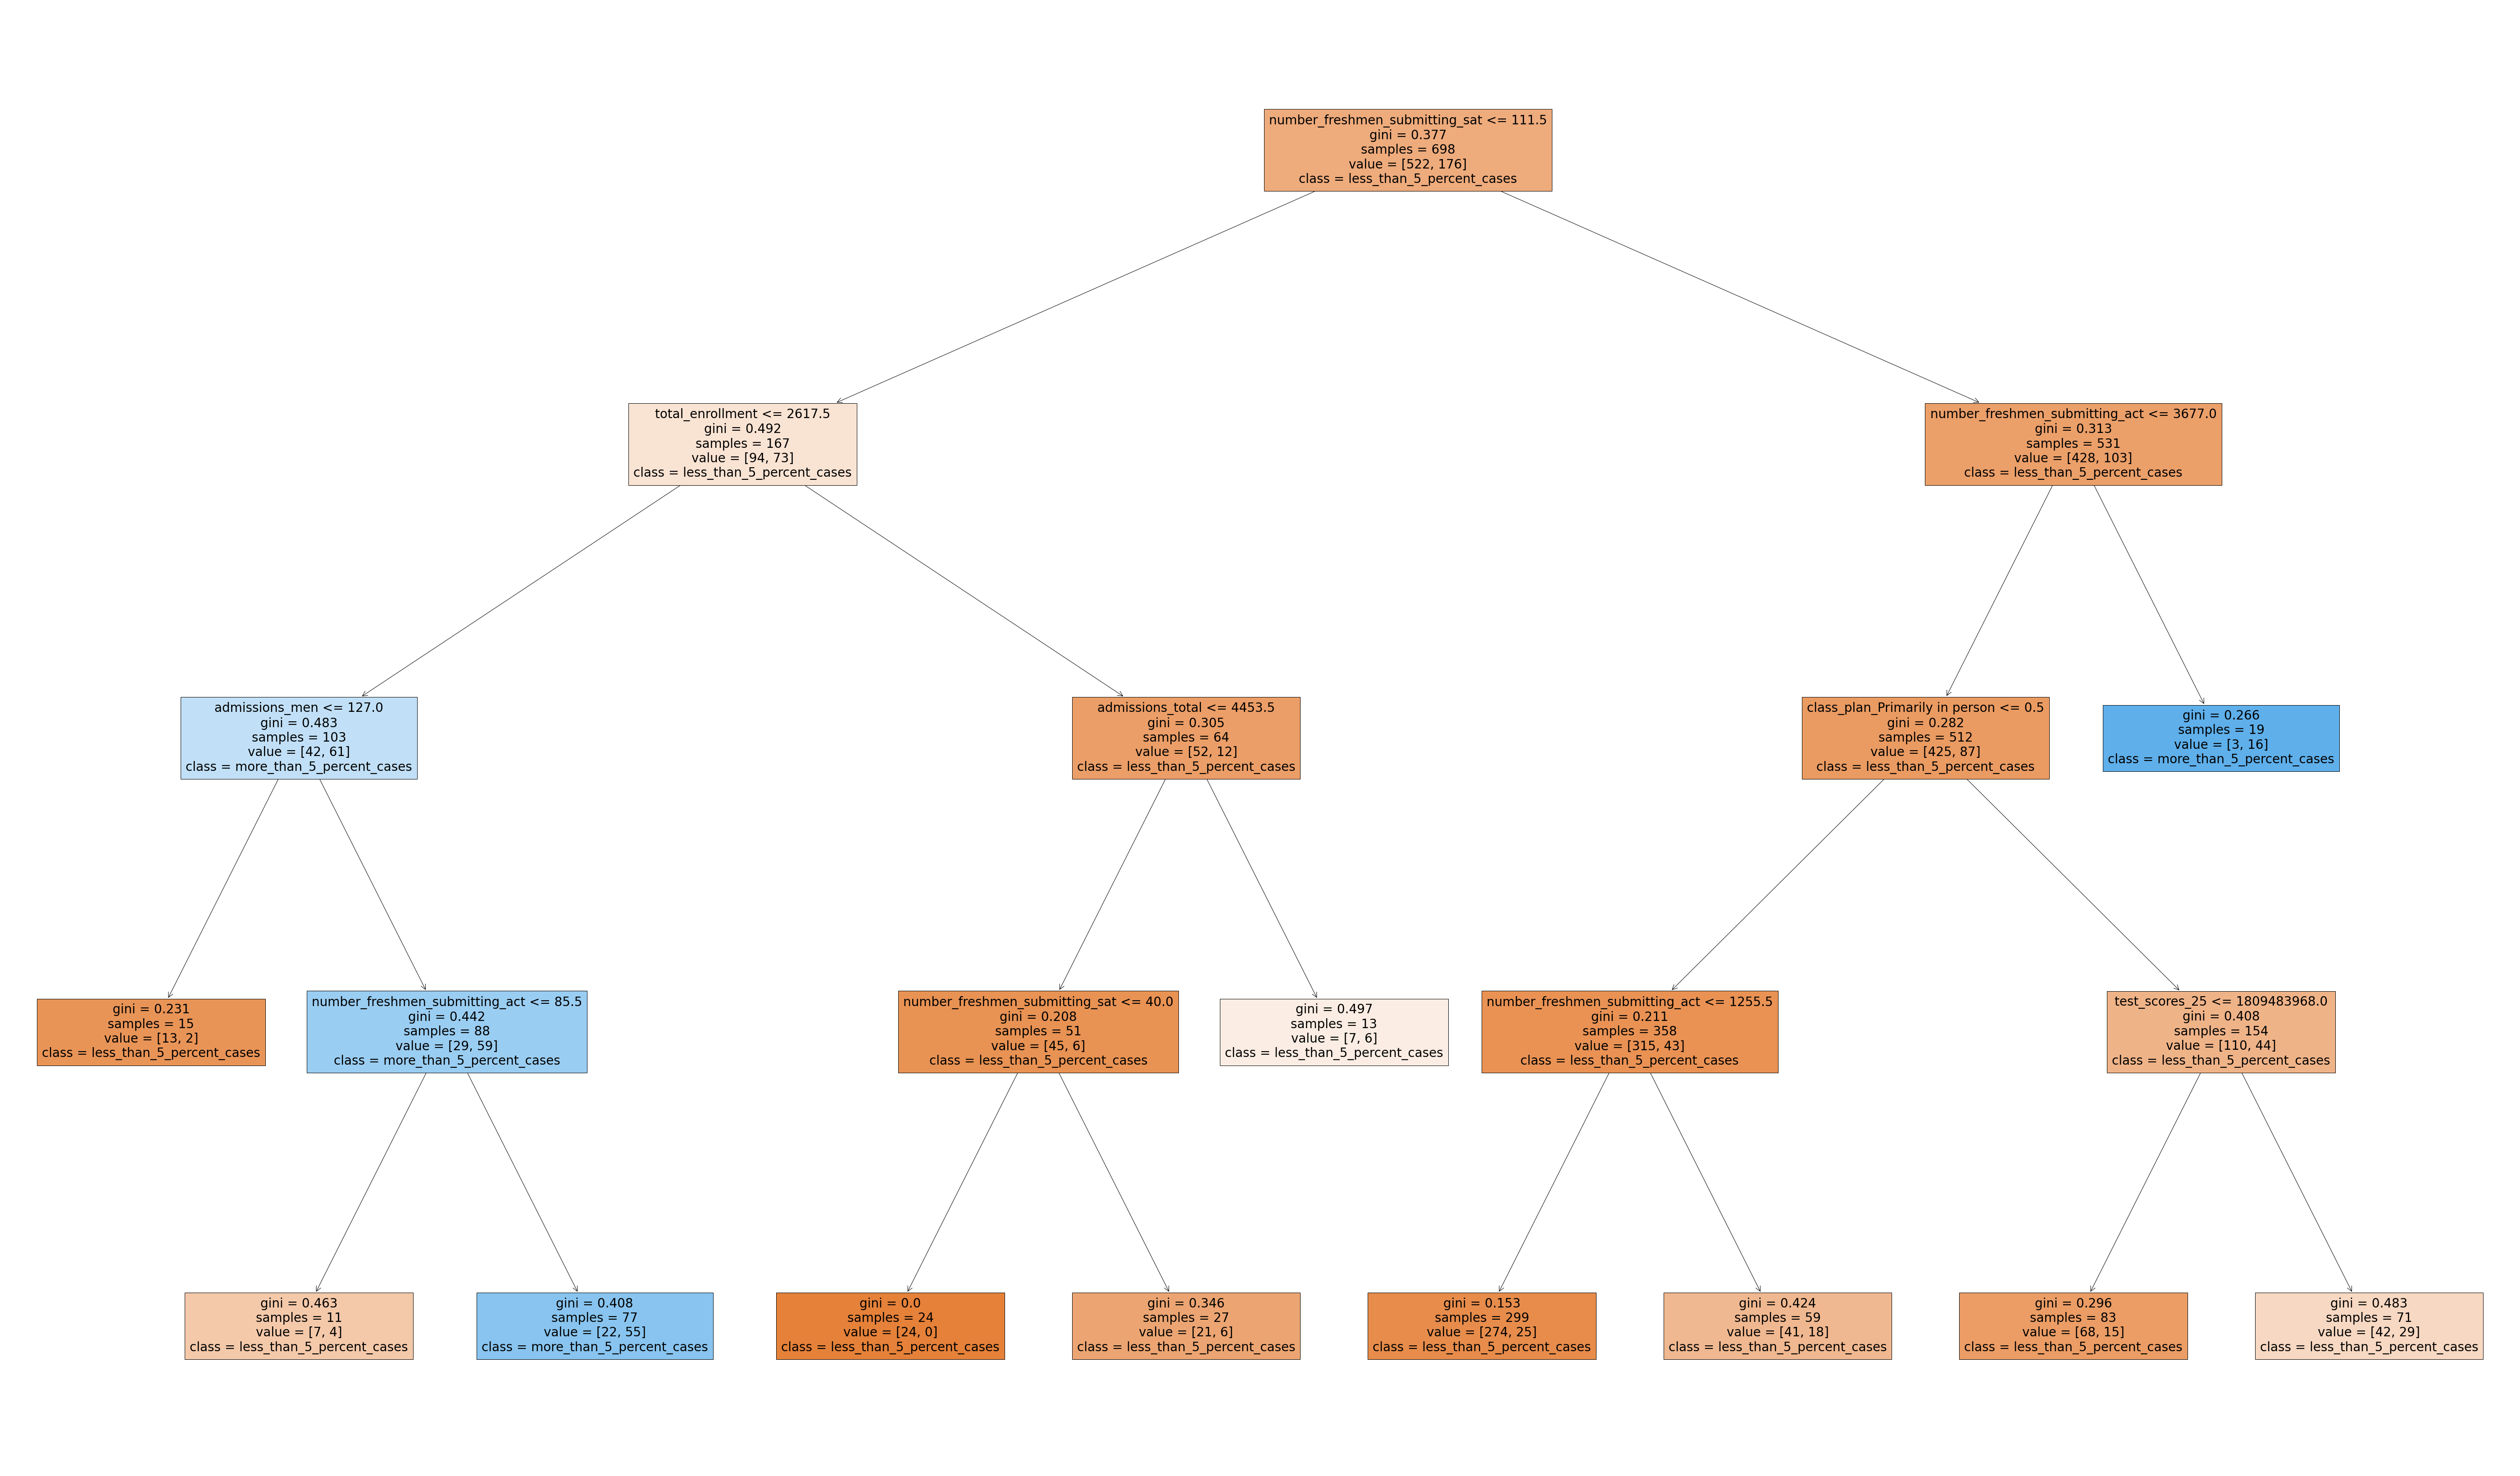

In [18]:
#plot best decision tree
plt.figure(figsize = (100, 60))
plot_tree(dt_gs.best_estimator_,
          feature_names = X_train.columns,
          class_names = ['less_than_5_percent_cases', 'more_than_5_percent_cases'],
          filled = True);

### Logisitic Regression

In [19]:
X = data.drop(columns=['greater_than_5', 'percent_infected', 'cases'])
y = data['greater_than_5']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, stratify = y, random_state=42)

ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

lr = LogisticRegression(max_iter = 3000)

lr_params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10]}


lr_gs = GridSearchCV(estimator = lr,
                   param_grid = lr_params,
                   cv = 5,
                   n_jobs = 4,
                   verbose =3)

lr_gs.fit(Z_train, y_train)

grid = lr_gs.best_estimator_

print(f'{grid.score(Z_test,y_test)}')
print(f'Best Logistic Regression Parameters: {lr_gs.best_params_}')
print(f'Score on training set: {grid.score(Z_train, y_train)}')
print(f'Score on testing set: {grid.score(Z_test, y_test)}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    7.3s


0.7942857142857143
Best Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l2'}
Score on training set: 0.8194842406876791
Score on testing set: 0.7942857142857143


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    8.8s finished


### Adaboost

In [20]:
#Adaboost Gridsearch
X = data.drop(columns=['greater_than_5', 'percent_infected', 'cases'])
y = data['greater_than_5']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80,stratify = y, random_state=42)

ada = AdaBoostClassifier()

ada_params = {'n_estimators': [50, 100, 200], 'learning_rate': [1]}

ada_gs = GridSearchCV(ada, ada_params, cv = 5)

ada_gs.fit(X_train, y_train)


print(f'Best Adaboost Parameters: {ada_gs.best_params_}')
print(f'Score on training set: {ada_gs.score(X_train, y_train)}')
print(f'Score on testing set: {ada_gs.score(X_test, y_test)}')

Best Adaboost Parameters: {'learning_rate': 1, 'n_estimators': 100}
Score on training set: 0.8896848137535817
Score on testing set: 0.7828571428571428


### Neural Net

In [19]:
X = data.drop(columns=['greater_than_5', 'percent_infected', 'cases'])
y = data['greater_than_5']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, stratify = y, random_state=42)

ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(Z_train.shape[1],)) )
model.add(Dropout(0.5)) 
model.add(Dense(16, activation='relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(1, activation='sigmoid')) 
early_stop = EarlyStopping(patience = 5)
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['acc','Recall','Precision'])
results = model.fit(Z_train, y_train, 
                          validation_data=(Z_test, y_test),
                         epochs=100, batch_size=32,
                         verbose=0,
                        callbacks = [early_stop])
pd.DataFrame(results.history)

,loss,acc,recall,precision,val_loss,val_acc,val_recall,val_precision
0,0.815464,0.568768,0.437500,0.275986,0.593474,0.737143,0.454545,0.476190
1,0.661747,0.670487,0.346591,0.346591,0.524260,0.777143,0.227273,0.666667
2,0.631786,0.707736,0.227273,0.370370,0.498563,0.777143,0.204545,0.692308
3,0.652208,0.687679,0.238636,0.333333,0.486636,0.800000,0.272727,0.800000
4,0.610391,0.730659,0.244318,0.438776,0.473510,0.794286,0.227273,0.833333
5,0.574431,0.733524,0.244318,0.447917,0.466737,0.800000,0.250000,0.846154
6,0.545039,0.732092,0.244318,0.443299,0.459570,0.800000,0.227273,0.909091
7,0.571421,0.732092,0.198864,0.432099,0.457770,0.805714,0.250000,0.916667
8,0.551872,0.734957,0.204545,0.444444,0.452179,0.811429,0.295455,0.866667
9,0.532147,0.752149,0.261364,0.516854,0.446624,0.811429,0.295455,0.866667


#### Random Forest

In [20]:
#Random Forest Gridsearch
X = data.drop(columns=['greater_than_5', 'percent_infected', 'cases'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, stratify = y, random_state=42)

rf = RandomForestClassifier()

rf_params = {
    'n_estimators':[50, 100, 200],
    'max_depth': [10, 15, 25],
    'max_features': [10,20],
    'min_samples_split':[5,10,15],
    'min_samples_leaf': [5, 10, 15]
}

rf_gs = GridSearchCV(rf, rf_params, cv = 5, n_jobs = 4)

rf_gs.fit(X_train, y_train)

print(f'Best Random Forest Score: {rf_gs.best_score_}')
print(f'Best Random Forest Parameters: {rf_gs.best_params_}')

Best Random Forest Score: 0.7865570400822199
Best Random Forest Parameters: {'max_depth': 25, 'max_features': 20, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}


Model performance WITHOUT Football Conference Dummies (43 Features)
- DT - .81/.76
- LR - .80/.80
- ADA Boost - .84/.79
- NN - .76/.80
- RF - .79

Model performance WITH Football Confererence Dummies  (135 Features)
- DT - .81/.76
- LR - .82/.79
- ADA Boost - .89/.78
- NN - .80/.79
- RF - .79


#### Interpretting Best Model 

- The best model was a Logistic Regression (due to the lack of overfitting and interpretability). There was a marginal difference when including the dummied football conference variables so we will interpret the coefficients with them present. 


In [21]:
print(f'Logistic Regression Intercept: {grid.intercept_}')
print(f'Logistic Regression Coefficient: {grid.coef_}')

Logistic Regression Intercept: [-1.29729336]
Logistic Regression Coefficient: [[-0.15289526 -0.01619415  0.04483928  0.05309187  0.07627471  0.01825278
  -0.01992938  0.16534004 -0.11355029  0.0284807   0.08154344 -0.03539927
   0.0840736  -0.02153865 -0.01767601  0.06389531  0.13378699  0.07948503
  -0.041675   -0.08951023  0.10363118 -0.00598889 -0.03267286  0.02376073
  -0.03169537  0.         -0.03005668 -0.03842245  0.02826394  0.08316503
   0.07400775 -0.02742451  0.05807651  0.11770434 -0.01121566 -0.04239375
   0.12147451 -0.0700699   0.04369839  0.02888315  0.07046694 -0.01609877
   0.         -0.04947576  0.0901425  -0.00588898 -0.02347848  0.11985458
  -0.00277445 -0.0026653  -0.07218664  0.08241756 -0.03447219 -0.06097407
   0.00315229  0.00092093 -0.04642584 -0.08360951  0.08813064 -0.03871865
  -0.03913567 -0.04030461 -0.01254834  0.09108389 -0.04357997 -0.04152428
   0.01470679 -0.0061506  -0.0326548  -0.18140973  0.06787066  0.02535983
   0.04025538  0.01534118  0.02629

In [22]:
coef_list = list(zip(np.exp(grid.coef_[0]),X.columns))

In [23]:
coef_df = pd.DataFrame(coef_list)
coef_df.rename(columns = {0:'coef', 1: 'feature'}, inplace = True)

In [24]:
coef_sorted = coef_df.sort_values(['coef'], ascending = False)

In [25]:
coef_sorted.head(10)

,coef,feature
7,1.179794,number_freshmen_submitting_act
122,1.146858,class_plan_Primarily in person
16,1.143149,football_conference_Big Ten Conference
36,1.129161,football_conference_Great Plains Athletic Conf...
47,1.127333,football_conference_Michigan Intercollegiate A...
115,1.125873,bar_closures_Reopened
33,1.124911,football_conference_Great Midwest Athletic Con...
83,1.116982,football_conference_Southeastern Conference
84,1.114228,football_conference_Southern Athletic Association
112,1.110848,restaurant_limits_Reopened to Dine-in Service


Interpretation of Coefficients
- Quatitative Features
   - for every 1 unit increase in number_freshmen_submitting_act, the institution is ~1.179 times as likely to have a significant amount of covid cases (defined as 5% of institution population contracting covid), all else held constant. 
- Categorical Features
  - If an institution's class plan is Primarily in person, the institution is ~1.147 times as likely to have a significant amount of covid cases (defined as 5% of institution population contracting covid), all else held constant. 

In [26]:
y_preds = lr_gs.predict(Z_test)
confusion_matrix(y_test, y_preds)

array([[128,   3],
       [ 33,  11]])

In [27]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

In [28]:
print("True Negatives: " + str(tn))
print()
print("False Positives: " + str(fp))
print()
print("False Negatives: " + str(fn))
print()
print("True Positives: " + str(tp))

True Negatives: 128

False Positives: 3

False Negatives: 33

True Positives: 11


#### Baseline Accuracy

In [29]:
y.value_counts(normalize = True)
#Baseline accuacy is .747995

0    0.747995
1    0.252005
Name: greater_than_5, dtype: float64

#### Mapping Logistic Regression Model Predictions 

In [30]:
#reload orginial dataframe do have state values (removed in the modeling process)
data_original = pd.read_csv('datasets/combined_df.csv')

In [31]:
#Create dataframe with model predictions on train and test data
y_preds_test = lr_gs.predict(Z_test)
y_preds_train = lr_gs.predict(Z_train)
y_preds_test = pd.DataFrame(data = y_preds_test, columns = ['y_preds'], index = X_test.index.copy())
y_preds_train = pd.DataFrame(data = y_preds_train, columns = ['y_preds'], index = X_train.index.copy())

#Merge predictions into one df 
y_preds_df = pd.merge(y_preds_test, y_preds_train, how = 'outer', left_index = True, right_index = True)

#Merge predictions onto dummied df used in the modeling process
df_out = pd.merge(data, y_preds_df, how = 'left', left_index = True, right_index = True)

#Merge dummied df with predictions onto the original df with state values
df_all = pd.merge(df_out, data_original, how = 'left', left_index = True, right_index = True)

In [32]:
#fill null values in y_predictions df with null values
y_preds_df.fillna(value = 0, inplace = True)
#combine y predictions from train and test into one column and drop other columns
df_all['y_preds'] = y_preds_df['y_preds_x'] + y_preds_df['y_preds_y']
df_all.drop(columns = ['y_preds_x', 'y_preds_y'], inplace = True)
#check to make sure values are only 0 and 1
df_all['y_preds'].unique()

array([0., 1.])

In [33]:
#Create new df with state, target and prediction
df_map = df_all[['state', 'greater_than_5_x', 'y_preds']]

In [37]:
usa = gpd.read_file('./States_21basic/states.shp')

geo_df = df_map[['state', 'y_preds']]

dg = geo_df.groupby('state').mean()
dg.reset_index(level = 0, inplace = True)
dg['state'].replace('Washington, D.C.', 'District of Columbia', inplace = True)

usa = usa.merge(dg, how = 'left', left_on = 'STATE_NAME', right_on = 'state')[['STATE_NAME', 'geometry', 'y_preds']]
usa.drop(usa.loc[(usa['STATE_NAME'] == 'Alaska') | (usa['STATE_NAME'] == 'Hawaii'), :].index, inplace = True)

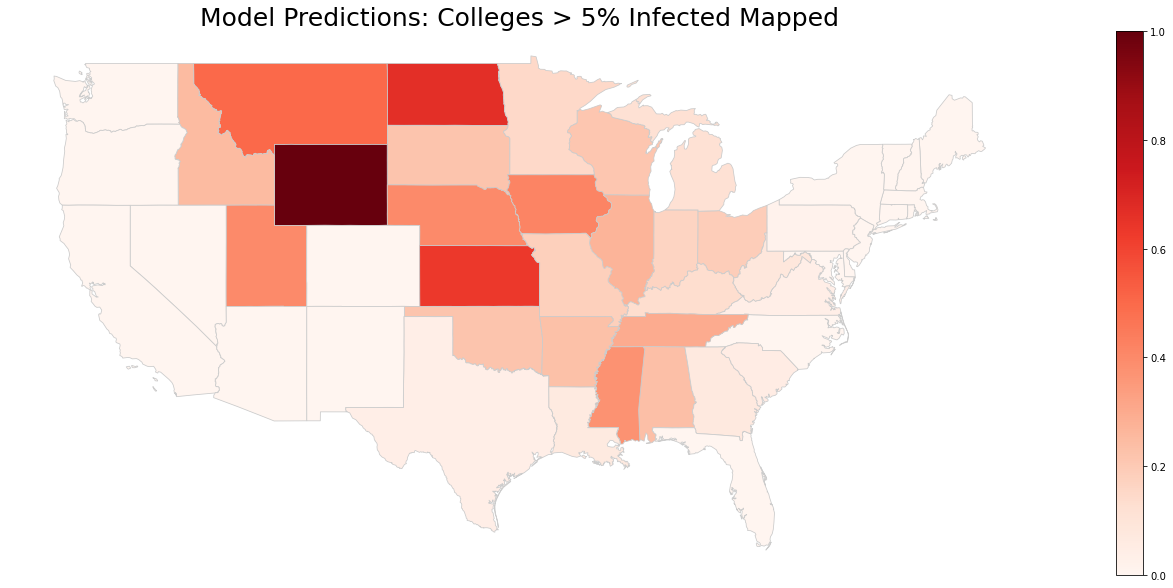

In [40]:
variable = 'y_preds' # set the value column that will be visualised
vmin, vmax = 0, 1 # set the range for the choropleth values
fig, ax = plt.subplots(1, figsize = (30,10)) # create figure and axes for Matplotlib
ax.axis('off') # remove the axis
ax.set_title('Model Predictions: Colleges > 5% Infected Mapped', fontdict = {'fontsize':'25', 'fontweight':'3'}) # add a title
sm = plt.cm.ScalarMappable(cmap = 'Reds', norm = plt.Normalize(vmin = vmin, vmax = vmax)) # Create colorbar legend
sm.set_array([]) # empty array for the data range
fig.colorbar(sm) # add the colorbar to the figure
usa.plot(column = variable, cmap = 'Reds', linewidth = 0.8, ax = ax, edgecolor = '0.8'); # create map
plt.savefig('./images/model_predictions_colleges_greater_5_mapped.png', bbox_inches = "tight")

In [ ]:
#export 
df_map.to_csv('./datasets/state_target_prediction.csv', index=False)